In [221]:
import numpy as np
import reedsolo as rs
import matplotlib.pyplot as plt

In [222]:
def KBCode(message,R="00",G="01",B="10",W="11",encoding="11",encryptionPercentage=30) :
    
    #Le KBCode à une largeur de 17 pixels pour une longeur de 2 cibles + une en-tête + le nombre de blocs divisé par 4 (4 blocs par colonnes)
    #Le nombre de blocs total est inconnu pour le moment
    #La 17 ligne sera une ligne d'alignement qui permettra en plus d'indiquer le sens du code, elle sera ajoutée à la matrice finale
    matrixCode = np.zeros((16,8+1+1))
    data1 = ["00","01","10","11",encoding,"00","00","00"]
        
    #Conversion du message en binaire
    def conversionMessage(message) :    
        def convertLetterBin(letter) :
            code=[]
            string_binary_value="{0:b}".format(letter)
            if(len(string_binary_value)%2 != 0) :
                string_binary_value = '0'+string_binary_value
            for i in range(0,len(string_binary_value),2) :
                code.append(string_binary_value[i]+string_binary_value[i+1])
            while len(code) != 4 :
                code.insert(0,"00")
            return code
        messageConverti = []
        for letter in message :
            messageConverti.append(convertLetterBin(letter))
        return messageConverti
    
    #Création des deux cibles à gauche de la matrice
    def preWriteKBCode(matrixCode) :
        target =  np.array([["11","11","11","11","11","11","11","11"],
                            ["11","00","00","00","00","00","00","11"],
                            ["11","00","11","11","11","11","00","11"],
                            ["11","00","11","00","00","11","00","11"],
                            ["11","00","11","00","00","11","00","11"],
                            ["11","00","11","11","11","11","00","11"],
                            ["11","00","00","00","00","00","00","11"],
                            ["11","11","11","11","11","11","11","11"]],dtype=str)
        target2 = target.copy()
        matrixCode=np.concatenate((target,target2),axis=0,dtype=str) 
        
        return matrixCode
    
    def addMessage(matrixCode,message,encoding) :
        #En-tête
        #Encryption taille du message
        blocNumber = len(message)*4
        binNumber = bin(blocNumber)[2:]
        if(len(binNumber)%2 != 0) :
            binNumber = '0'+binNumber
        for i in range(0,len(binNumber),2) :
            data1.append(binNumber[i]+binNumber[i+1])
        while len(data1) != 16:
            data1.insert(8,"00")
        
        #Ajout de l'en-tête gauche à la matrice
        arrayd1 = np.array(data1,dtype=str)
        matrixCode = np.insert(matrixCode,8,arrayd1,axis=1)

        #Formatting in string multiple of 16 to be a rectangle
        def addFilling(string,redundancy=False) :
            if(redundancy) : 
                fillchar= bytearray([75])
            else :
                fillchar = bytearray([0])
            (_,r) = divmod(len(string)*4,16)
            filling = int((16-r)/4)
           

            string = string + (filling*fillchar)
            return string
        

        #Création du message + redondance 
            #Reed solomon
        if(encoding=="00"):
            message = message.encode(encoding='UTF-8')
        else:
            message = message.encode(encoding='ASCII')
        nsym = int((len(message)*encryptionPercentage)/100)
        rsc=rs.RSCodec(nsym)
        encodage =rsc.encode(message)
            #Découpage en deux blocs (ajout de remplissage si non multiple de 16)
        msg = encodage[:len(message)]
        msg = addFilling(msg)
        red = encodage[-nsym:]
        red = addFilling(red, redundancy=True)
            #Conversion en pixels
        msgEnc = conversionMessage(msg)
        redEnc = conversionMessage(red)
        #Reshape en deux matrices de hauteur 16
        msgMat = np.reshape(msgEnc, (-1, 16))
        msgMat = msgMat.transpose()
        redMat = np.reshape(redEnc, (-1, 16))
        redMat = redMat.transpose()

        #Mise en place des matrices avant de les ajouter au code final
        upperHalfMsg = msgMat[0:8,:]
        lowerHalfMsg = msgMat[8:16,:]
        upperHalfRed =  redMat[0:8,:]
        lowerHalfRed =  redMat[8:16,:]
        lowerHalfData = np.concatenate((lowerHalfRed,lowerHalfMsg),axis=1)
        upperHalfData = np.concatenate((upperHalfMsg,upperHalfRed),axis=1)
        data = np.concatenate((upperHalfData,lowerHalfData),axis=0)
        #Insérer le vecteur en-tête redondant
        data=np.insert(data,len(data[0]),arrayd1,axis=1)
        #Ajouter la barre d'alignement et cibles (je sais pas pourquoi il veut une double transposition...)
        matrixCode = np.concatenate((matrixCode,data),axis=1)
        alignment = np.array([R if i%2==0 else W for i in range(len(matrixCode[0]))],dtype=str)
        matrixCode = matrixCode.transpose()
        matrixCode=np.insert(matrixCode,len(matrixCode[0]),alignment,axis=1)
        matrixCode = matrixCode.transpose()
        return matrixCode

    matrixCode = preWriteKBCode(matrixCode)
    matrixCode = addMessage(matrixCode,message,encoding)
    return matrixCode
    



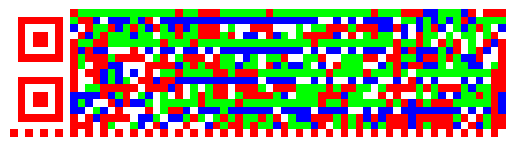

In [223]:
messageTestUTF8 = "Le KBCode est l'avenir des QRCodes! Il est de taille variable ce qui lui permet de contenir beaucoup d'informations en plus d'être posable sur des surfaces cylindriques"
messageTestASCII = "abcde"
matrixCode = KBCode(messageTestUTF8,encoding="00") #"00" car UTF-8

def affichage(matrixCode,R="00",G="01",B="10",W="11"):
    mCopy = matrixCode.tolist()
    #Transforme la valeur binaire en caractère représentant la couleur
    def BinToRGBW(Mat,R,G,B,W):
        KB = Mat
        for i in range(0,len(Mat)):
            for j in range(0, len(Mat[i])):
                if (Mat[i][j] == R):
                    KB[i][j] = (255, 0, 0)
                if (Mat[i][j] == G):
                    KB[i][j] = (0, 255, 0)
                if (Mat[i][j] == B):
                    KB[i][j] = (0, 0, 255)
                if (Mat[i][j] == W):
                    KB[i][j] = (255, 255, 255)
        return KB
    mCopy = BinToRGBW(mCopy,R,G,B,W)
    plt.imshow(mCopy)
    plt.axis('off')
    plt.show()

affichage(matrixCode)

In [224]:
from math import ceil
def KBDecode(matrice,encryptionPercentage=30) :
    m = np.array(matrice)
    def getHeaderInfo(h):
        encoding = h[4]
        messageLength=h[8:16]
        return (encoding,messageLength)
    (encoding,lenArray) = getHeaderInfo(m[:,8])
    if(encoding != "00") :
        return "Méthode de décodage non implémentée!"
    def getBlockNumber(lenArray):
        strLen = ''.join(lenArray)
        return int(strLen,base=2)
    bNumber = getBlockNumber(lenArray)
    data = m[0:16]
    data = data.transpose()
    data = data[9:len(m[0])-1]
    data = data.transpose()
    (_,r) = divmod(bNumber,16)
    filling = int((16-r)/4)
    nbColRed = (int(ceil((((bNumber/4)+filling)*encryptionPercentage)/100))*4)/16
    print(nbColRed)
    #dataUpper = data[0:8]
    #dataLower = data[8:16]
    #dataLower = dataLower.transpose()
    #dataLowerRed = data[0:nbColRed]
    #dataLower = data[nbColRed:len(dataLower)]
    #dataLower = np.concatenate(dataLower,dataLowerRed,len(dataLower),axis=0)
    #dataLower = dataLower.transpose()

    

KBDecode(matrixCode)


13.0
